**Пояснения к данным и задаче**:
В этом тестовом задании вам предлагается решить задачу классификации транзакции (в данном случае - покупка в интернет-магазине): является она мошеннической или нет.

Вам будут предоставлены тренировочный и тестовый наборы данных(без целевой переменной). Формат входных данных подробно описан в файле Variable_Definitions.csv.

В качестве метрики мы предлагаем вам воспользоваться f1-мерой.

В качестве решения мы ожидаем:

·         jupyter notebook с описанным ходом решения;

·         результаты предсказания на тестовом множестве.

 

Дополнительно, просим дать развернутые ответы на вопросы:

·         Какие дополнительные данные могли бы помочь в данной задаче?

·         Какой методы для решения задачи вы бы хотели использовать, но не успели?

·         Какая бизнес-метрика будет, на ваш взгляд, основной в данной задаче?

 

Решение выложите в публичный репозиторий github/gitlab и отправьте ссылку на него.

**Стоит разобраться в данных и в сути задачи**

Нам предстоит находить мошеннические операции(FraudResult). Определимся, для чего это делается , помимо морально-этичиских норм.
При одобрении мошеннических операций интернет-магазин будет обязан вернуть деньги на карту владельца, даже если товар уже был отгружен мнимому покупателю. Более того, на магазин может быть наложен штраф в зависимости от объемов мошенничества, а при повторении подобных ситуаций — особые санкции от международных платежных систем. В общем, хорошо будет только мошеннику.

Все определения мошеннических операций сводятся к определению нестандартного поведения клиента.
Например - час назад вы сделали покупку в магазине в Новосибирске, а сейчас уже платите за ужин в ресторане на Монмартре.
Или вы решили совершить неожиданно крупный перевод или покупку, а, возможно, и серию небольших, но постоянных перечислений.
Оплата в российском интернет-магазине осуществляется картой, выпущенной в США, а плательщик находится в Испании.

Посмотрим, какие у нас есть данные для работы:

 - TransactionId	Уникальный идентификатор транзакции на платформе - пользы в данном признаке для нашей работы не будет.

 - BatchId - транзакции могут обьединяться в пакеты. Забегая вперед - во всех транзакциях, которые пересылались пакетами, не было мошеннических. Этот признак может косвенно говорить о честной транзакции. Но только в нашем случае.

 - AccountId, SubscriptionId, CustomerId - все это идентификаторы наших пользователей. По ним мы можем определить пользователя и составлять портрет его поведения. И поскольку тестовый датасет является продолжением трейнового, то они нам пригодятся. Но нужно понимать, что обученную модель нельзя будет использовать для данных с других платформ. На них с этими же идентификационными номерами окажутся совсем иные пользователи. Еще один плюс этих признаков - при наличии у  одного уникального пользователя нескольких аккаунтов можно говорить об увиличении риска мошеннических операций от него.

 - CurrencyCode, CountryCode - в нашем случае совершенно бесполезный признак(у нас всего один вид валюты/код страны). Но, часто это хороший признак, для выявления мошеннической транзакции. Например,  ограничения по географии платежей.

 - ProviderId, ProductId, ProductCategory, ChannelId, PricingStrategy - нужные признаки. Спорным возможно будет только поставщик. Определенные товары явно пользуются у мошенников большим спросом и при покупке таких стоит обратить более пристально е внимание на транзакцию. Ну и изменение типа канала оплаты у одного покупателя может говорить о мошеннической операции.

 - Amount, Value - важные признаки. 'Стоимость сделки. Положительный говорит о списании/отрицательный о зачислении' - как я понимаю, это относится к счету покупателя? И эти цифры говорят о списании и зачислении денег на счет покупателя? Будем считать так. По нашим данным видно, что сумма мошеннической сделки обычно больше средней или медианной. Но интересно, что часть фрод транзакций имеет отрицательное значение. А, значит, мошеннической транзацией признано зачисление денег на счет покупателя? Это странно. Хотелось бы более точного обьяснения, это бы помогло.

 - TransactionStartTime - важный признак. По исследованиям, которые мне удалось найти, по времени транзакции можно судить, относитя ли она к мошеннической. Например, часто мошеннические операции происходят в ночное время. Или же количество обычных операций в обеденное время уменьшается, тогда , как мошенничесих - возрастает.

 - ClientProfile, TrasactionCategory - должны быть важные признаки. Здорово, когда за тебя делают твою работу. Но похоже внешняя система не самым лучшим образом справляется. Все эти категории TrasactionCategory равномерно присутствуют в транзакциях отмеченных, как мошеннические.

 - FraudResult - собственно, целевой признак.

# <a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [1. Анализ данных](#0.)
* [2. Подготовка данных](#8.)
* [3. Обучение модели:](#10.)
    * [LogisticRegression](#11.)
    * [CatBoostClassifier](#12.)
    * [Ошибки модели](#13.)
    * [Выводы](#14.)
* [4. Результаты на тестовой выборке](#16.)
* [5 Дополнительные вопросы](#17.)

## 1. Анализ данных
<a name="0."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
info = pd.read_csv('Variable_Definitions.csv')

In [3]:
info

,Column Name,Definition
0,TransactionId,Уникальный идентификатор транзакции на платформе
1,BatchId,Уникальное идентификатор присваевыемый пакету ...
2,AccountId,Уникальный идентификатор пользователя на платф...
3,SubscriptionId,Уникальный идентификатор идентифицирующий подп...
4,CustomerId,Уникальный идентификатор привязанный к аккаунту
5,CurrencyCode,Валюта страны
6,CountryCode,Цифровой географический код страны
7,ProviderId,Поставщик товара
8,ProductId,Идентификатор купленного товара
9,ProductCategory,Категория товара


In [4]:
train.tail()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory
79885,18019,129395,4841,3829,3795,EUR,49,4,6,financial_services,2,-5000.0,5000,2019-01-31 23:08:18,2,0,0,1
79886,102758,87434,2577,3326,2994,EUR,49,5,1,airtime,3,1000.0,1000,2019-01-31 23:44:44,4,0,3,1
79887,10757,114753,4841,3829,2994,EUR,49,4,6,financial_services,2,-50.0,50,2019-01-31 23:45:42,2,0,0,2
79888,104292,100831,2669,2002,3088,EUR,49,5,15,financial_services,3,45000.0,45000,2019-01-31 23:51:33,2,0,2,3
79889,54329,11357,572,2950,909,EUR,49,1,15,financial_services,3,50000.0,50000,2019-01-31 23:54:12,2,0,1,1


In [5]:
def inf (df):
    df.info()
    print('='*80)
    print(df.describe())
    print('='*80)
    print('Наличие полных дубликатов :',df.duplicated().sum())
    
inf(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79890 entries, 0 to 79889
Data columns (total 18 columns):
TransactionId           79890 non-null int64
BatchId                 79890 non-null int64
AccountId               79890 non-null int64
SubscriptionId          79890 non-null int64
CustomerId              79890 non-null int64
CurrencyCode            79890 non-null object
CountryCode             79890 non-null int64
ProviderId              79890 non-null int64
ProductId               79890 non-null int64
ProductCategory         79890 non-null object
ChannelId               79890 non-null int64
Amount                  79890 non-null float64
Value                   79890 non-null int64
TransactionStartTime    79890 non-null object
PricingStrategy         79890 non-null int64
FraudResult             79890 non-null int64
ClientProfile           79890 non-null int64
TrasactionCategory      79890 non-null int64
dtypes: float64(1), int64(14), object(3)
memory usage: 11.0+ MB
       Trans

In [6]:
inf(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15772 entries, 0 to 15771
Data columns (total 17 columns):
TransactionId           15772 non-null int64
BatchId                 15772 non-null int64
AccountId               15772 non-null int64
SubscriptionId          15772 non-null int64
CustomerId              15772 non-null int64
CurrencyCode            15772 non-null object
CountryCode             15772 non-null int64
ProviderId              15772 non-null int64
ProductId               15772 non-null int64
ProductCategory         15772 non-null object
ChannelId               15772 non-null int64
Amount                  15772 non-null float64
Value                   15772 non-null int64
TransactionStartTime    15772 non-null object
PricingStrategy         15772 non-null int64
ClientProfile           15772 non-null int64
TrasactionCategory      15772 non-null int64
dtypes: float64(1), int64(13), object(3)
memory usage: 2.0+ MB
       TransactionId        BatchId     AccountId  Subscri

**В некоторых признаках нужно поменять класс. Артефактов в данных не видно, как и попусков. Полных дубликатов нет.**

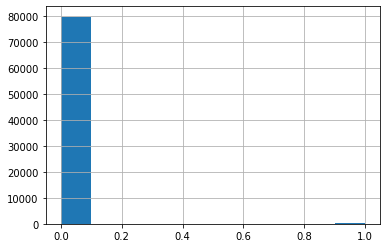

In [7]:
#дисбаланс классов, было бы странно, если бы фрод операций было много. Но тут их совсем мало.
#но вред они наносят значительный
train['FraudResult'].hist()

count      140.000000
mean     11004.654357
std      13297.256641
min          5.000000
5%        1000.000000
50%       5400.000000
99%      50000.000000
max      86000.000000
Name: Value, dtype: float64


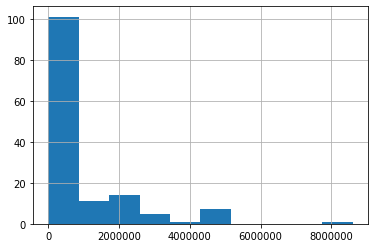

In [8]:
#посмотрим на распределение сумм платежей тех операций, которые признаны мошенническими
print((train.query('FraudResult == 1')['Value']/100).describe(percentiles = [.05, .5, .99]))
train.query('FraudResult == 1')['Value'].hist()

count    79750.000000
mean        68.407952
std        405.663335
min          0.020000
50%         10.000000
75%         50.000000
99%        800.000000
max      24000.000000
Name: Value, dtype: float64


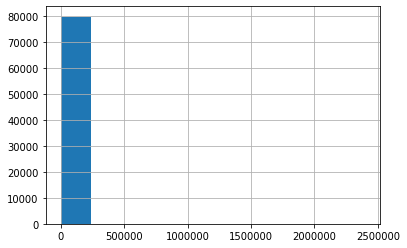

In [9]:
print((train.query('FraudResult == 0')['Value']/100).describe(percentiles = [.5, .75, .99]))
train.query('FraudResult == 0')['Value'].hist()

**99% обычных транзакций укладываются в суммы до 80.000, а максимальная транзакция составила 2.4 млн.
тогда как в мошеннических транзакциях меньше 100.000 всего пять штук**

**Что это нам дает:
возможно выделить категорию суммы транзакции свыше 100.000 и более пристально присматриваться к таким операциям.**

In [10]:
train.query('FraudResult == 1')['ProductCategory'].value_counts()

financial_services    116
airtime                17
utility_bill            5
transport               2
Name: ProductCategory, dtype: int64

**среди мошенников популярностью пользуются четыре категории товаров**

In [11]:
train.query('FraudResult == 0').groupby('ProductCategory')['Value'].describe(percentiles = [.5, .75, .99])

,count,mean,std,min,50%,75%,99%,max
ProductCategory,,,,,,,,
airtime,37698.0,6143.681575,21325.364677,33.0,1500.0,5400.0,40000.0,2000000.0
data_bundles,1563.0,3634.165067,12040.890389,500.0,1000.0,2000.0,49907.0,284900.0
financial_services,37474.0,6312.398410,53530.666700,2.0,200.0,5000.0,90000.0,2400000.0
movies,168.0,11067.857143,6501.683996,700.0,7000.0,14000.0,30310.0,49000.0
other,2.0,500.000000,0.000000,500.0,500.0,500.0,500.0,500.0
ticket,206.0,100315.533981,69178.260024,10000.0,80000.0,80000.0,400000.0,480000.0
transport,21.0,91142.857143,92624.125213,26000.0,62000.0,90000.0,394400.0,448000.0
tv,1048.0,19182.189885,45884.759991,900.0,11000.0,12000.0,288400.0,288400.0
utility_bill,1570.0,17309.271975,22498.875969,1115.0,11200.0,16650.0,106300.0,315000.0


**ещё один варинт - если сумма транзакции превышает 99% квантиль по определенной категории товара, то на неё стоиит обратить внимание**

In [12]:
train.query('FraudResult == 1')['ProductId'].value_counts()
#среди мошенников популярностью пользуется товар под идентификатором 15, тоже можно учесть.

15    112
3      11
10      6
21      4
9       3
5       2
22      1
6       1
Name: ProductId, dtype: int64

In [13]:
train.query('FraudResult == 1')['TrasactionCategory'].value_counts()
#рискованность транзакции по мнению внешней системы напрямую с мошенничискими операциями не связана

3    49
1    47
2    44
Name: TrasactionCategory, dtype: int64

**вопросы к транзакциям:**

In [14]:
train.query('AccountId == 572')
# по какому принципу тут проставлены фродовые операции?
#операция в 1.9 млн и в 2.45 млн являются фродовыми,  а операция на 2.4 млн нет,  
#при всех остальных почти одинаковых общих признаках
#это странно.

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory
76569,135363,27780,572,2950,909,EUR,49,5,15,financial_services,3,95000.0,95000,2019-01-28 17:28:02,2,0,1,3
76662,103109,90376,572,2950,909,EUR,49,5,15,financial_services,3,1900000.0,1900000,2019-01-28 18:28:42,2,1,1,2
76667,16361,10711,572,2950,909,EUR,49,5,15,financial_services,3,2450000.0,2450000,2019-01-28 18:32:24,2,1,1,3
76693,135392,17770,572,2950,909,EUR,49,5,15,financial_services,3,2400000.0,2400000,2019-01-28 18:56:37,2,0,1,2
77481,110741,17467,572,2950,909,EUR,49,5,15,financial_services,3,80000.0,80000,2019-01-29 15:54:52,2,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79613,138110,608,572,2950,909,EUR,49,1,15,financial_services,3,78000.0,78000,2019-01-31 17:49:24,2,0,1,2
79615,28319,24129,572,2950,909,EUR,49,6,10,airtime,3,79000.0,79000,2019-01-31 17:52:21,2,0,1,2
79619,111462,132704,572,2950,909,EUR,49,5,15,financial_services,3,150000.0,150000,2019-01-31 17:57:21,2,0,1,1
79630,98613,94820,572,2950,909,EUR,49,6,10,airtime,3,150000.0,150000,2019-01-31 18:01:15,2,0,1,3


In [15]:
train.query('FraudResult == 1 and Amount <=0')
#могут ли операции по зачислению денег на счет клиента(если я правильно трактовал описание колонки Amount) быть мошенническими?

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory
55822,56954,76447,4249,4429,7339,EUR,49,4,3,airtime,2,-900000.0,900000,2019-01-10 15:48:59,4,1,2,2
55841,73797,127642,4249,4429,7339,EUR,49,4,10,airtime,2,-500000.0,500000,2019-01-10 16:03:35,4,1,2,3
56035,87682,101919,4249,4429,7401,EUR,49,4,3,airtime,2,-500000.0,500000,2019-01-10 21:27:12,4,1,2,1
60834,126320,93368,4249,4429,7429,EUR,49,4,3,airtime,2,-500000.0,500000,2019-01-15 11:09:57,0,1,2,3
68918,71725,62457,4841,3829,865,EUR,49,4,6,financial_services,2,-1005.0,1005,2019-01-23 09:15:37,2,1,0,1


In [16]:
train.query('SubscriptionId ==  3829')
#особый покупатель - 27304 транзакции
#у него куча аккаунтов, собственно, он не один такой, у кого зарегистрированно несколько аккаунтов.
#все операции - по зачислению на карту
# и всего одна мошенническая операция на 1005 EUR, модель её точно не распознает.

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory
1,73770,15642,4841,3829,4406,EUR,49,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08,2,0,0,2
4,28195,38780,4841,3829,988,EUR,49,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21,2,0,0,3
7,100640,38561,4841,3829,2858,EUR,49,4,6,financial_services,2,-500.0,500,2018-11-15 03:45:13,2,0,0,2
11,33857,126394,4841,3829,3052,EUR,49,4,6,financial_services,2,-40.0,40,2018-11-15 04:32:42,2,0,0,2
18,64044,117733,4841,3829,3105,EUR,49,4,6,financial_services,2,-10.0,10,2018-11-15 04:54:18,2,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79877,95890,87510,4841,3829,2943,EUR,49,4,6,financial_services,2,-20.0,20,2019-01-31 22:26:05,2,0,0,3
79879,36616,15952,4841,3829,908,EUR,49,4,6,financial_services,2,-150.0,150,2019-01-31 22:30:22,2,0,0,2
79881,95249,67944,4841,3829,908,EUR,49,4,6,financial_services,2,-50.0,50,2019-01-31 22:33:48,2,0,0,1
79885,18019,129395,4841,3829,3795,EUR,49,4,6,financial_services,2,-5000.0,5000,2019-01-31 23:08:18,2,0,0,1


**Итогом - к сожалению, в условии задачи не сказано, каким образом проставлены маркеры фрод операций. Были ли это результаты анти-фрод системы, не проверенные СБ. Или же они уже совершенно точно определены и перепроверены соответствующими специалистами, как мошеннические. От этого зависит, можем ли мы удалять часть операций определенных как фродовые, но, возможно, такими не являющимися. Обучить модель на неверных данных - беда, получим принцип GIGO. 
этот вопрос вполне можно было задать клиенту.
я решил придерживаться того, что все данные верны. Хотя было велико желание почистить данные. Это явно помогло бы конечному результату.**

## 2. Подготовка данных;
<a name="9."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [17]:
#приведем даты в порядок
train['TransactionStartTime'] = pd.to_datetime(train['TransactionStartTime'])
test['TransactionStartTime'] = pd.to_datetime(test['TransactionStartTime'])

In [18]:
print(train['TransactionStartTime'].is_monotonic)
#хронологический порядок дат соблюден

True


In [19]:
#создадим признак 
#есть теория, что вероятность мошеннических операций в разное время отличается
def make_features(row):
    return row.hour
    
train['hour'] = train['TransactionStartTime'].apply(make_features)
test['hour'] = test['TransactionStartTime'].apply(make_features)

In [20]:
def make_features_dayofweek(row):
    return row.dayofweek
    
#train['dayofweek'] = train['TransactionStartTime'].apply(make_features_dayofweek)
#test['dayofweek'] = test['TransactionStartTime'].apply(make_features_dayofweek)

In [21]:
train = train.drop(['TransactionId', 'CurrencyCode', 'CountryCode','TransactionStartTime'], axis=1)
test = test.drop(['TransactionId', 'CurrencyCode', 'CountryCode','TransactionStartTime'], axis=1)
#данные столбцы не несут нагрузку

In [22]:
#закодируем признаки
#train = pd.get_dummies(train, drop_first=True)
#test = pd.get_dummies(test, drop_first=True)

In [23]:
#закодируем признаки
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
encoder.fit(train.loc[:,['ProductCategory']])
train.loc[:,['ProductCategory']] = pd.DataFrame(encoder.transform(train.loc[:,['ProductCategory']]),\
                                                   columns=['ProductCategory'])

train['ProductCategory'] = train['ProductCategory'].astype('int')

In [24]:
#закодируем признаки

test.loc[:,['ProductCategory']] = pd.DataFrame(encoder.transform(test.loc[:,['ProductCategory']]),\
                                                   columns=['ProductCategory'])

test['ProductCategory'] = test['ProductCategory'].astype('int')

In [25]:
from sklearn.preprocessing import StandardScaler
#масштабирование признаков
numeric = ['ProductId','ChannelId','ProviderId','BatchId','AccountId','SubscriptionId','CustomerId']
scaler = StandardScaler()
#scaler.fit(train[numeric])

#train[numeric] = scaler.transform(train[numeric])

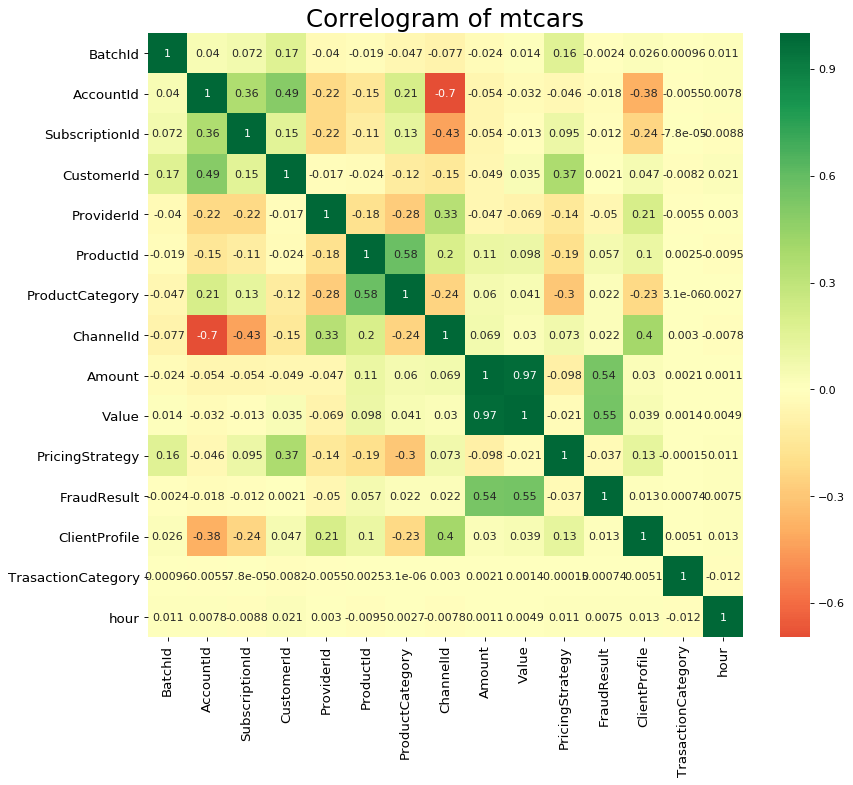

In [26]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(train.corr(), xticklabels=train.corr()\
            .columns, yticklabels=train.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Есть высокая корреляция между Amount и Value + FraudResult.
По теории от одного из них стоит избавиться(например от Amount) и построить дополнительный признак, говорящий о зачислении и списании.
Но практика показала, что их оба стоит оставить.
почему оставил весь набор идентификаторов клиента, писал в разборе данных.

**итоговая таблица**

In [27]:
train.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory,hour
0,36123,3957,887,4406,6,10,0,3,1000.0,1000,2,0,4,3,2
1,15642,4841,3829,4406,4,6,2,2,-20.0,20,2,0,0,2,2
2,53941,4229,222,4683,6,1,0,3,500.0,500,2,0,3,2,2
3,102363,648,2185,988,1,21,8,3,20000.0,21800,2,0,3,1,3
4,38780,4841,3829,988,4,6,2,2,-644.0,644,2,0,0,3,3


## 3. Обучение модели;
<a name="10."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from catboost import Pool, cv, CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import statistics

**разобьем данные**

**CatBoostClassifier**
 <a name="12."></a>

In [29]:
target = train['FraudResult']
features = train.drop('FraudResult', axis=1)

**только на таргет и тест, для проверки буду использовать кросс валидацию. после можно обучить модель на всех данных**

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=12349)


In [31]:
target_train.value_counts()[1] / target_train.value_counts()[0]*100

0.1755500568447803

In [32]:
target_test.value_counts()[1] / target_test.value_counts()[0]*100

0.1755441869796369

распределение классов по выборкам получилось равным

In [33]:
%%time
#через GPU на google collab CatBoost обучается быстро, там у меня результаты выходят хуже.
#может, он не так бъет данные, а может ещё что...
from catboost import CatBoostClassifier, Pool
#text_features=['ProductCategory']
cat_features =['BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId',
       'ProductId', 'ChannelId',
       'PricingStrategy', 'ClientProfile', 'TrasactionCategory',
       'hour', 'ProductCategory']



cat_model = CatBoostClassifier(iterations = 500,
                               learning_rate=0.1,     
                           loss_function='Logloss',
                           custom_metric = 'F1',
                           verbose=True,
                           cat_features=cat_features)

cv_dataset = Pool(data=features_train,
                  label=target_train,
                 cat_features=cat_features)


grid = { 'depth': [5,6]}

#grid = {'iterations':[500,1000],
#        'learning_rate': [0.1, 0.2, 0.03],
#         'depth': [4,5,6,7]}

grid_search_result = cat_model.grid_search(grid, 
                                       X=cv_dataset)

0:	loss: 0.0012843	best: 0.0012843 (0)	total: 3m 54s	remaining: 3m 54s
1:	loss: 0.0012077	best: 0.0012077 (1)	total: 8m 40s	remaining: 0us
Estimating final quality...
CPU times: user 24min 36s, sys: 2min 35s, total: 27min 11s
Wall time: 27min 29s


In [34]:
#лучшие параметры
grid_search_result['params']

{'depth': 6}

In [35]:
predict_CAT = cat_model.predict(features_test)
f1 = f1_score(target_test, predict_CAT)

In [36]:
print('F1 scorr на тестовой выборке составил:', f1)

F1 scorr на тестовой выборке составил: 0.8923076923076922


In [37]:
print('Точность на тестовой выборке составила :',precision_score(target_test, predict_CAT))

Точность на тостовой выборке составила : 0.9666666666666667


In [38]:
print('Полнота на тестовой выборке составила :',recall_score(target_test, predict_CAT))

Полнота на тостовой выборке составила : 0.8285714285714286


**важность признаков**

In [39]:
importances = cat_model.feature_importances_

feature_list = list(features_train.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,hour,18.907468
1,ProviderId,14.564338
2,ProductId,12.023857
3,CustomerId,11.250787
4,AccountId,8.403255
5,Value,7.975956
6,ClientProfile,5.591507
7,SubscriptionId,5.580484
8,Amount,4.914920
9,ProductCategory,4.018251


In [40]:
cat_model.save_model("cat_model_cft")

**Ошибки модели**
 <a name="13."></a>

на данном этапе нам удается обнаружить порядка 88.5% всех фрод операций. к сожалению, модель принимает некоторые обычные операции за фрод, но в 96.8 % случаев она делает правильные выводы.
Посмотрим, в каких случаях модель ошибается.

In [41]:
features_test['predict_CAT'] = predict_CAT

In [42]:
features_test['target_test'] = target_test

In [43]:
features_test['dif'] = features_test['predict_CAT'] - features_test['target_test']

In [44]:
features_test.query('dif != 0')

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,ClientProfile,TrasactionCategory,hour,predict_CAT,target_test,dif
18008,86494,4421,4038,4878,1,15,2,3,500000.0,500000,0,3,1,8,1.0,0,1.0
68918,62457,4841,3829,865,4,6,2,2,-1005.0,1005,2,0,1,9,0.0,1,-1.0
53492,117332,3519,2550,3956,5,15,2,3,2000000.0,2000000,2,1,3,10,0.0,1,-1.0
69563,64514,1609,2872,1988,3,15,2,3,100000.0,100000,2,0,3,20,0.0,1,-1.0
69568,136015,1609,2872,1988,3,15,2,3,100000.0,100000,2,0,1,20,0.0,1,-1.0
47034,135779,1520,695,1891,1,15,2,3,2000000.0,2000000,2,0,2,16,0.0,1,-1.0
64357,118851,953,162,1302,3,15,2,3,2000000.0,2000000,2,2,2,15,0.0,1,-1.0


**Выводы**
 <a name="14."></a>

Для улучшения качества мы могли бы обучить модель на полной выборке, не выделяя тестовую.

Возможно, хорошим вариантом будет дать модели возможность "сказать" не знаю. Например, задать пороги : ниже 0.5 - это обычная операция, от 0.5 до 0.9 - модель не уверена(отдадим принятие решения на откуп специалисту), выше 0.9 - мошенническая операция..

Можно поизменять порог и заставить модель находить все фрод операции, но и зачислять к ним обычные. К чему это приведет - увеличится ручная обработка проверки транзакций(больше времени уйдет на проверку ответов модели). Больше уточняющих проверочных мероприятий от магазина по отношению к клиенту(документальное подверждение личности плательщика). В связи с чем возрастет негативная реакция клиентов и риск их дальнейшего отказа от услуг магазина(потеря клиента=потеря прибыли). 
Но судя по суммам фрод операций и дальнейшему негативному влиянию от них, возможно пожертвовать частью покупателей. Но все это естественно на усмотрение клиента. 

**обучение на полной выборке**

In [46]:
cat_features =['BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId',
       'ProductId', 'ChannelId',
       'PricingStrategy', 'ClientProfile', 'TrasactionCategory',
       'hour', 'ProductCategory']



cat_model_full = CatBoostClassifier(iterations = 500,
                           loss_function='Logloss',
                           custom_metric = 'F1',
                           verbose=True,
                           cat_features=cat_features)

cv_dataset_full = Pool(data=features,
                  label=target,
                 cat_features=cat_features)


grid = {
        'learning_rate': [0.1, 0.2],
        'depth': [5,6]}

grid_search_result_full = cat_model_full.grid_search(grid, 
                                       X=cv_dataset)

0:	loss: 0.0012843	best: 0.0012843 (0)	total: 3m 55s	remaining: 11m 45s
1:	loss: 0.0013201	best: 0.0012843 (0)	total: 7m 56s	remaining: 7m 56s
2:	loss: 0.0012077	best: 0.0012077 (2)	total: 12m 50s	remaining: 4m 16s
3:	loss: 0.0011476	best: 0.0011476 (3)	total: 17m 40s	remaining: 0us
Estimating final quality...


In [47]:
#лучшие параметры
grid_search_result_full['params']

{'depth': 6, 'learning_rate': 0.2}

In [48]:
importances = cat_model_full.feature_importances_

feature_list = list(features.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,ProductId,18.314479
1,ClientProfile,15.961417
2,hour,12.876686
3,ProviderId,10.645632
4,Value,8.998899
5,CustomerId,7.834692
6,Amount,6.934419
7,AccountId,5.137746
8,SubscriptionId,4.979310
9,PricingStrategy,3.339969


In [49]:
cat_model_full.save_model("cat_model_full_cft")

## 5. Результаты на тестовой выборке
<a name="16."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [50]:
#не полная модель
cat_model_cft = CatBoostClassifier()
cat_model_cft.load_model("cat_model_cft")

In [51]:
dataset_test = Pool(test, cat_features=cat_features)

In [52]:
test['FraudResult_cat_model_cft'] = cat_model.predict(dataset_test)

In [53]:
test.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,ClientProfile,TrasactionCategory,hour,FraudResult_cat_model_cft
0,96810,3933,3115,4380,1,8,7,3,11000.0,11330,2,0,1,1,0.0
1,114595,4841,3829,4380,4,6,2,2,-5000.0,5000,2,0,3,1,0.0
2,104610,3933,3115,4380,6,10,0,3,2000.0,2000,2,0,2,1,0.0
3,78588,835,3465,1180,5,15,2,3,10000.0,10000,2,2,2,2,0.0
4,59419,835,3465,1180,5,15,2,3,10000.0,10000,2,2,2,2,0.0


In [54]:
#модель обученная на всей выборке
cat_model_full_cft = CatBoostClassifier()
cat_model_full_cft.load_model("cat_model_full_cft")

In [55]:
test['FraudResult_cat_model_full_cft'] = cat_model.predict(dataset_test)

In [56]:
test.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,ClientProfile,TrasactionCategory,hour,FraudResult_cat_model_cft,FraudResult_cat_model_full_cft
0,96810,3933,3115,4380,1,8,7,3,11000.0,11330,2,0,1,1,0.0,0.0
1,114595,4841,3829,4380,4,6,2,2,-5000.0,5000,2,0,3,1,0.0,0.0
2,104610,3933,3115,4380,6,10,0,3,2000.0,2000,2,0,2,1,0.0,0.0
3,78588,835,3465,1180,5,15,2,3,10000.0,10000,2,2,2,2,0.0,0.0
4,59419,835,3465,1180,5,15,2,3,10000.0,10000,2,2,2,2,0.0,0.0


In [60]:
(test['FraudResult_cat_model_full_cft'] == test['FraudResult_cat_model_cft']).sum()

15772

**Обе модели сделали одинаковые предсказания на тестовой выборке**

## 6. Дополнительные вопросы
<a name="17."></a>
[<font size="2">(к содержанию)</font>](#1common.)

**Какие дополнительные данные могли бы помочь в данной задаче?**

Хотелось бы получать максимально больше информации о клиенте и его транзакциях.
Например:
-- Эти данные находятся на стороне платежной системы и вряд ли будут доступны:
    -- Страна банка, выпустившего карту.
    -- Количество платежей с карты.
    -- Платежная история банковской карты.

--  IP адрес устройства, с которого осуществляется платеж
-- Страна, из которой совершается платеж
-- если клиент ЮЛ, то направление его бизнеса

В общем все, что поможет определить нестандартное поведение и как можно четче обрисовать нам контур клиента.

**Какая бизнес-метрика будет, на ваш взгляд, основной в данной задаче?**

Прибыль.
Автоматическое отклонение сомнительных транзакций, защита интернет-магазина от последующих разбирательств с банками, платежными системами и реальными владельцами карт.  И, конечно же, минимизация репутационных и финансовых рисков. Репутация магазина не пострадает, и пользователи будут доверять такому ресурсу, а значит, их лояльность будет расти.

Но отклонение платежей может привести к потере клиентов, а значит, прибыли. Без должной настройки фильтры могут не пропускать значимые для интернет-магазина транзакции, что точно не понравится покупателям.

**Какой методы для решения задачи вы бы хотели использовать, но не успели?**

 - больше посвятить времени созданию признаков, удалению не важных. Категорировать клиентов по сумме транзакции(свыше 100.000 более пристальное рассмотрение), виду продукции и товара. Поразбивал бы по кластерам через KMeans, а почему нет.
 - попробовал бы другие библиотеки (XGBoost , LightGBM, обучил нейронную сеть в Keras, подготовил данные и обучил бы линейную регрессию)
 - ручная настройка весов классов
 - дать модели возможность "сказать" не знаю. Например, задать пороги : ниже 0.5 - это обычная операция, от 0.5 до 0.9 - модель не уверена(отдадим принятие решения на откуп специалисту), выше 0.9 - мошенническая операция.